# Dataset

The data represents ~900 matches of Super Smash Brother Ultimate that have been scrambled such that the consecutive rows does not represents consecutive matches. The data consists of four columns: 'Red', 'Blue', 'Yellow', and 'Winner'. 'Red', 'Blue', and 'Yellow' all represent a player, and the data found in that column represents the character that they had chosen. The 'Winner' column, as the name suggest, represents the winner of the game. The values in this column can only be 'Red', 'Blue', or 'Yellow'. All games consist of either two or three players, and one winner. 

For example, suppose I have the following row:
<br>-Mii Brawler, Simon, Kazuya, Blue

<br>This row can be interpreted as:
<br>-Red chose Mii Brawler
<br>-Blue chose Simon.
<br>-Yellow chose Kazuya.
<br>-Blue was the winner of the match.

It is important to note that this dataset does not represent standard gameplay, but rather it represents a specific ruleset that is used for tournaments between the three players. Most of the rules do not affect this data, but there are two significant differences between what is expected from casual play and this data. 

1. Each tournament consists of 89 unique characters. Because of this, each player may not necessarily be choosing characters they want to play, but rather they are choosing characters they have to play.

2. If a player looses a match, they are no longer able to continue playing that character for the rest of the tournament. In other words, this means that winning characters can be picked again. As such, 'good' characters will appear more frequently than that of 'bad' characters.

This data is my own, and the original source of the information can be found on the following google sheets table:
<br>https://docs.google.com/spreadsheets/d/196jTJCAh3Jz7j_gHuBdrZ-vCk0fYGtu_18HIfpCMDrI/edit?usp=sharing


    


# Task

I have two distinct goals with this dataset:

1. I want to have extensive visualizations of the dataset. Due to the sheer quantity of characters, only a select number of visualizations will be shown here; the rest will be found in their own respective files. This includes the following:
<br>-For each character, find their total picks, total wins, total losses, total picks for each player, wins for each player, and losses for each player. 
<br>-For each player, I want to see their total wins and losses. I also want to have the data for each character that is relevant to the player gathered together. In other words, each player has multiple graphs with all of the characters, and the graphs display total picks, total losses, and total wins.

2. I have separated out 150 matches worth of information from the original data. The remaining of the original dataset will be used as training data, and the separated data will be used as test data. Ultimately, I will be using an artificial neural network in an attempt to make predictions about the 'Winner' column. I will be testing a wide range of hidden layers in order to determine


# Expectations

The minimum accuracy you could expect from a model is 33%, but I will be personally surprised if any model can predict with >50% accuracy. The reason for me thinking this is that the the data is arguably random. This data excludes very important information, such as the stage that the match was played on. It also is reliant on human behavior, which in of itself is very unreliable. No player for any game is going to play with 100% consistency, and that can have an impact on how they play. A player can be using their best character, but it is very much possible for them to still lose because they became distracted or because they made a mistake. In other words, I can take two almost identical matches, but the winner may not be the same between them.

With that being said, attempting to make predictions is not completely a lost cause. There are two important trends that a model might be able to take advantage of in order to accurately predict with the information:

1. Overall player consistency. Although a player might not always be consistent, you can get an understanding of how skilled they are by looking at multiple matches at once. An example of this is Blue, who is the winner of ~50% of the matches. As such, a model might do well to be biased towards predicting Blue to be the winner of a match. 

2. Each player has a handful of 'mains.' A 'main' is a character that a player has a tendency to play, and typically a player is going to be better at using their main than they will be with an average character. They will also be more likely to use their main in a match than the other players, due to the player going out of their way to try to get that character for using in the tournament. Ideally, a model would be able to take advantage of these facts to assist in its predictions. Although I don't intend on testing the model's ability to predict player mains, I will be paying attention to see if a player's mains become apparent in the model's predictions.


Red's Mains:
<br>-Mario 
<br>-Donkey Kong
<br>-Kirby
<br>-Peach
<br>-Daisy
<br>-Villager
<br>-Banjo & Kazooie
<br>-Min Min

Blue's Mains:
<br>-Ganondorf
<br>-Shulk
<br>-Incineroar
<br>-Byleth
<br>-Pyra & Mythra

Yellow's Mains:
<br>-Link
<br>-Lucas
<br>-Little Mac
<br>-Hero

# Imports

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense

# Setup

In [83]:
EMPTY_DICT = { 'All':0,
               'Red':0,
               'Blue':0,
               'Yellow':0 }

leCharacter = LabelEncoder()
lePlayer = LabelEncoder()

lePlayer.fit_transform(['Red','Blue', 'Yellow'])

orderedCharacters = ["Mario", "Donkey Kong", "Link", "Samus", "Dark Samus", "Yoshi", "Kirby", "Fox", "Pikachu", "Luigi",
            "Ness", "Captain Falcon", "Jigglypuff", "Peach", "Daisy", "Bowser", "Ice Climbers", "Sheik", "Zelda",
            "Dr. Mario", "Pichu", "Falco", "Marth", "Lucina", "Young Link", "Ganondorf", "Mewtwo", "Roy", "Chrom",
            "Mr. Game & Watch", "Meta Knight", "Pit", "Dark Pit", "Zero Suit Samus", "Wario", "Snake", "Ike",
            "Pokemon Trainer", "Diddy Kong", "Lucas", "Sonic", "King Dedede", "Olimar", "Lucario", "R.O.B.",
            "Toon Link", "Wolf", "Villager", "Mega Man", "Wii Fit Trainer", "Rosalina & Luma", "Little Mac",
            "Greninja", "Mii Brawler", "Mii Swordfighter", "Mii Gunner", "Palutena", "Pac-Man", "Robin", "Shulk",
            "Bowser Jr.", "Duck Hunt", "Ryu", "Ken", "Cloud", "Corrin", "Bayonetta", "Inkling", "Ridley", "Simon",
            "Richter", "King K. Rool", "Isabelle", "Incineroar", "Piranha Plant", "Joker", "Hero", "Banjo & Kazooie",
            "Terry", "Byleth", "Min Min", "Steve", "Sephiroth", "Pyra & Mythra", "Kazuya", "Sora", "Random"]


# Disable Sections

In [84]:
PLOT_ALL_CHARACTERS = True
PLOT_ALL_PLAYERS = True
MACHINE_LEARNNG = False

# Functions

In [85]:
class Character:
    def __init__(self):
        self.id = -1
        self.total = EMPTY_DICT.copy()
        self.wins = EMPTY_DICT.copy()
        self.losses = EMPTY_DICT.copy()
        self.winRate = EMPTY_DICT.copy()
        
class CharacterHolder:
    def __init__(self):
        self.characters = {}
        
    def addDF(self, df):
        for index, row in df.iterrows():
            characters = {
                'Red': row['Red'],
                'Blue': row['Blue'],
                'Yellow': row['Yellow']
            }
    
            winner = row['Winner']
            self.addMatch(characters, winner)

    def addMatch(self, characters, winner):
        for player, characterName in characters.items():
            if (not pd.isna(characterName)):
                if (not characterName in self.characters):
                    self.characters[characterName] = Character()
                character = self.characters[characterName]
                
                character.total['All'] += 1
                character.total[player] += 1
                
                if (player == winner):
                    character.wins['All'] +=1
                    character.wins[player] +=1
                else:
                    character.losses['All'] +=1
                    character.losses[player] +=1
                character.winRate[player] = round((character.wins[player] / character.total[player]) * 100,2)
                character.winRate['All'] = round((character.wins['All'] / character.total['All']) * 100,2)
                
    def getMax(self):
        max = 0
        for _, info in self.characters.items():
            if (info.total['All'] > max):
                max = info.total['All']
        return max
                
        
def preproccess(df):
    df.dropna(thresh=2, inplace = True);
    if (df.shape[1] == 4):
        df.dropna(subset=['Winner'])
    df.replace('', 'NaN', inplace = True)
    return df

def plotSetup(subPath):
    if not os.path.exists(subPath):
        os.makedirs(subPath)
    plt.style.use('dark_background')

def characterPlot(info, title, axs, max):    
    labels = ['Yellow','Blue','Red','All']
    val = [info['Yellow'], info['Blue'], info['Red'], info['All']]
    axs.set_title(title)
    axs.barh(labels, val, color=[(180/255,170/255,0/255),(0/255,0/255,150/255),(160/255,0/255,0/255),(100/255,100/255,100/255)])
    if (title != 'Win Rate'):    
        axs.set_xlabel('Games')
        axs.set_xticks(np.arange(0,max+2, step=2))
        for i, v in enumerate(val):
            axs.text(v+0.2, i, str(v))
    else:
        axs.set_xlabel('Win Percentage')
        axs.set_xticks(np.arange(0,105, step=5))
        for i, v in enumerate(val):
            axs.text(v+0.2, i, str(v)+'%')
            
def playerPlot(characters, max, saveToPNG):
    subPath = './plots/player/'
    plotSetup(subPath)

    for player in ['All','Red', 'Blue', 'Yellow']:
        valTotal = [characters[character].total[player] for character in orderedCharacters]

        valWins = [characters[character].wins[player] for character in orderedCharacters]

        valLosses = [characters[character].losses[player] for character in orderedCharacters]

        valWinRate = [characters[character].winRate[player] for character in orderedCharacters]
        totalPath = subPath+'/'+player+'_total.png'
        winPath = subPath+'/'+player+'_wins.png'
        lossPath = subPath+'/'+player+'_losses.png'
        winRatePath = subPath+'/'+player+'_winRate.png'
        
        playerSubPlot(player+' - Total', valTotal, max, 2, 'Games', saveToPNG, totalPath)
        playerSubPlot(player+' - Wins', valWins, max, 2, 'Games', saveToPNG, winPath)
        playerSubPlot(player+' - Losses', valLosses, max, 2, 'Games', saveToPNG, lossPath)
        playerSubPlot(player+' - Win Rate', valWinRate, 105, 5, 'Win Percentage', saveToPNG, winRatePath)
                               
def playerSubPlot(title, val, maxX, step, xLabel, saveToPNG, path):
        labels = [character for character in orderedCharacters]
        fig, axs = plt.subplots(figsize=(10, 18))
        axs.barh(labels, val, color=['white', (170/255,170/255,200/255)], height=0.6)
        axs.set_title(title)
        axs.set_xlabel(xLabel)
        axs.invert_yaxis()
        axs.set_xticks(np.arange(0, maxX+step, step=step))
        for i, v in enumerate(val):
            num = str(v) + ('%' if maxX == 105 else '') 
            axs.text(v+0.2, i, num)
        plt.show()
        
        if (saveToPNG):
            fig.savefig(path, bbox_inches='tight')
        
        
def reorderCharacters(oldHolder):
    newHolder = CharacterHolder()
    i = 1
    for key in orderedCharacters:
        newHolder.characters[key] = oldHolder.characters[key]
        newHolder.characters[key].id = i
        i += 1
        
    return newHolder
    
def encode(df, columns):
    encodedDF = df.copy()
    for column in columns:
        encodedDF[column] = leCharacter.fit_transform(encodedDF[column])
    return encodedDF

def MLP_model(hidden_layers):
    model = Sequential()
    model.add(Dense(4, activation='relu'))
    model.add(Dense(hidden_layers, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# All Data - Preprocess & Analysis

In [86]:
allDF = pd.read_csv('all.csv')
allDF = preproccess(allDF)

characterDict = CharacterHolder()
characterDict.addDF(allDF)
characterDict = reorderCharacters(characterDict)


    

# All Data - Character Visualization

In [87]:
max = characterDict.getMax()
if (PLOT_ALL_CHARACTERS):
    subPath = './plots/characters/'
    plotSetup(subPath)


    for name, info in characterDict.characters.items():
        fig, axs = plt.subplots(4,1, figsize=(8,10))
        plt.subplots_adjust(hspace=1)
        path = subPath+'/'+str(info.id)+'_'+name+'.png'
        characterPlot(info.total, 'Total Games', axs[0], max)
        characterPlot(info.wins, 'Wins', axs[1], max)
        characterPlot(info.losses, 'Losses', axs[2], max)
        characterPlot(info.winRate, 'Win Rate', axs[3], max)
        
        fig.suptitle(name)
        fig.savefig(path, bbox_inches='tight')
        plt.close()
    

# All Data - Player Visualization

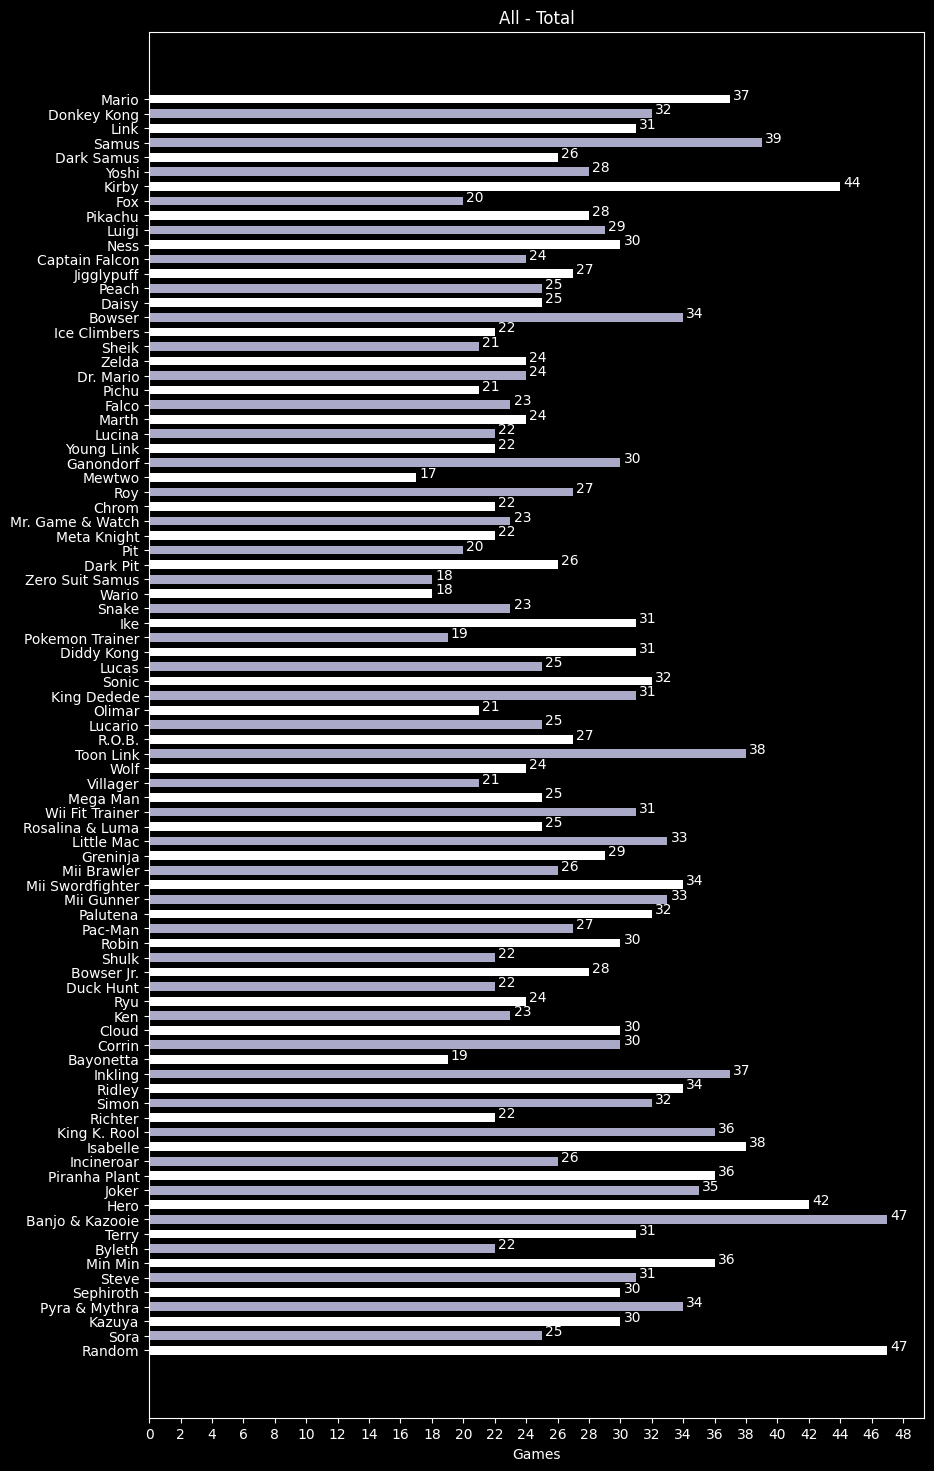

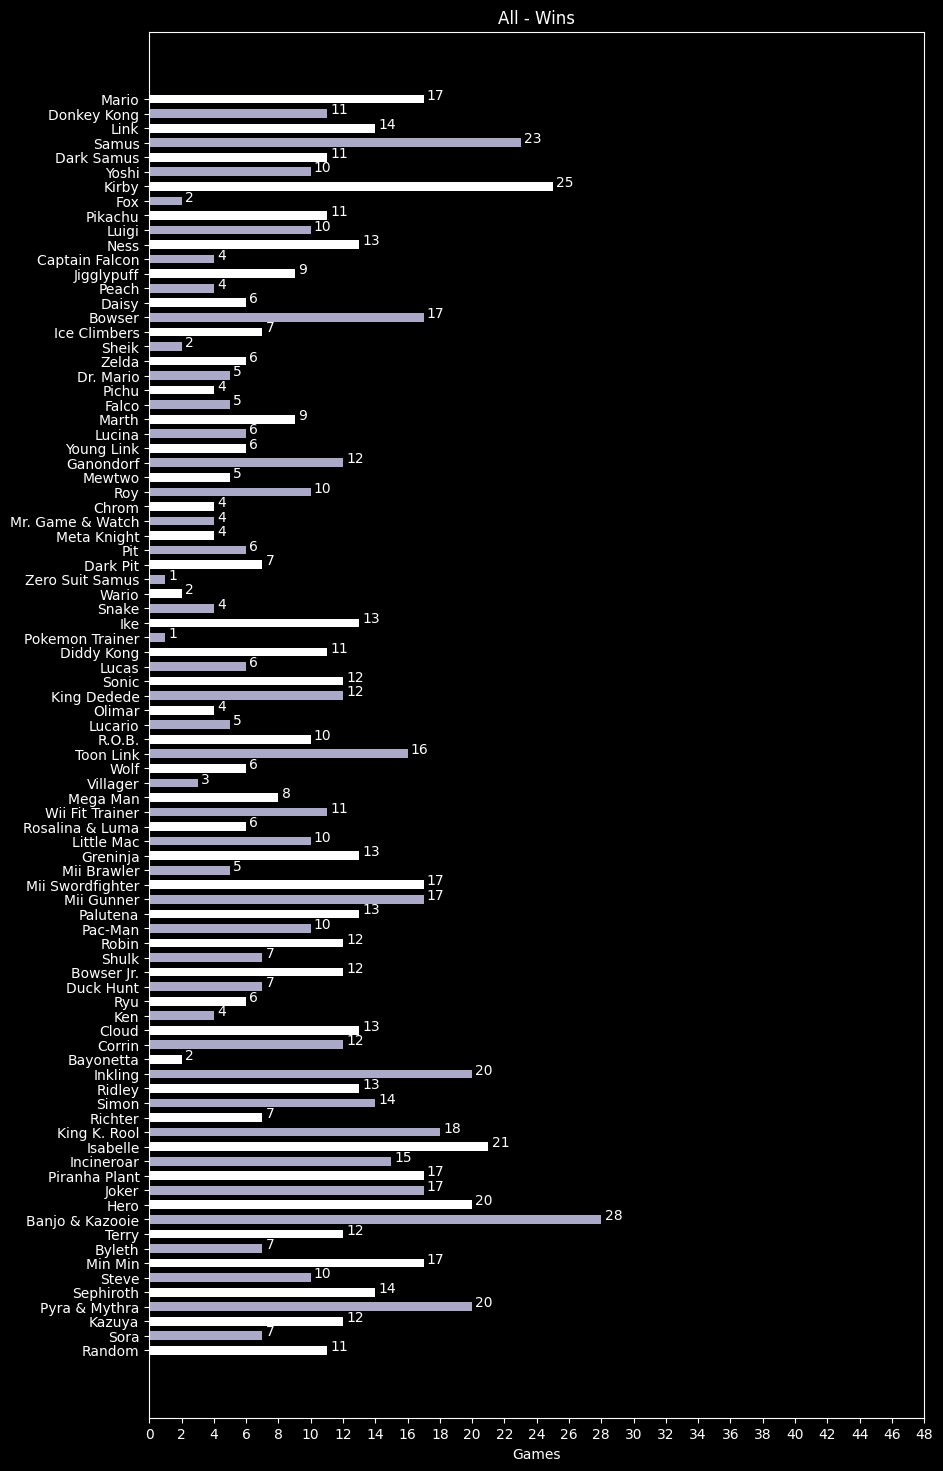

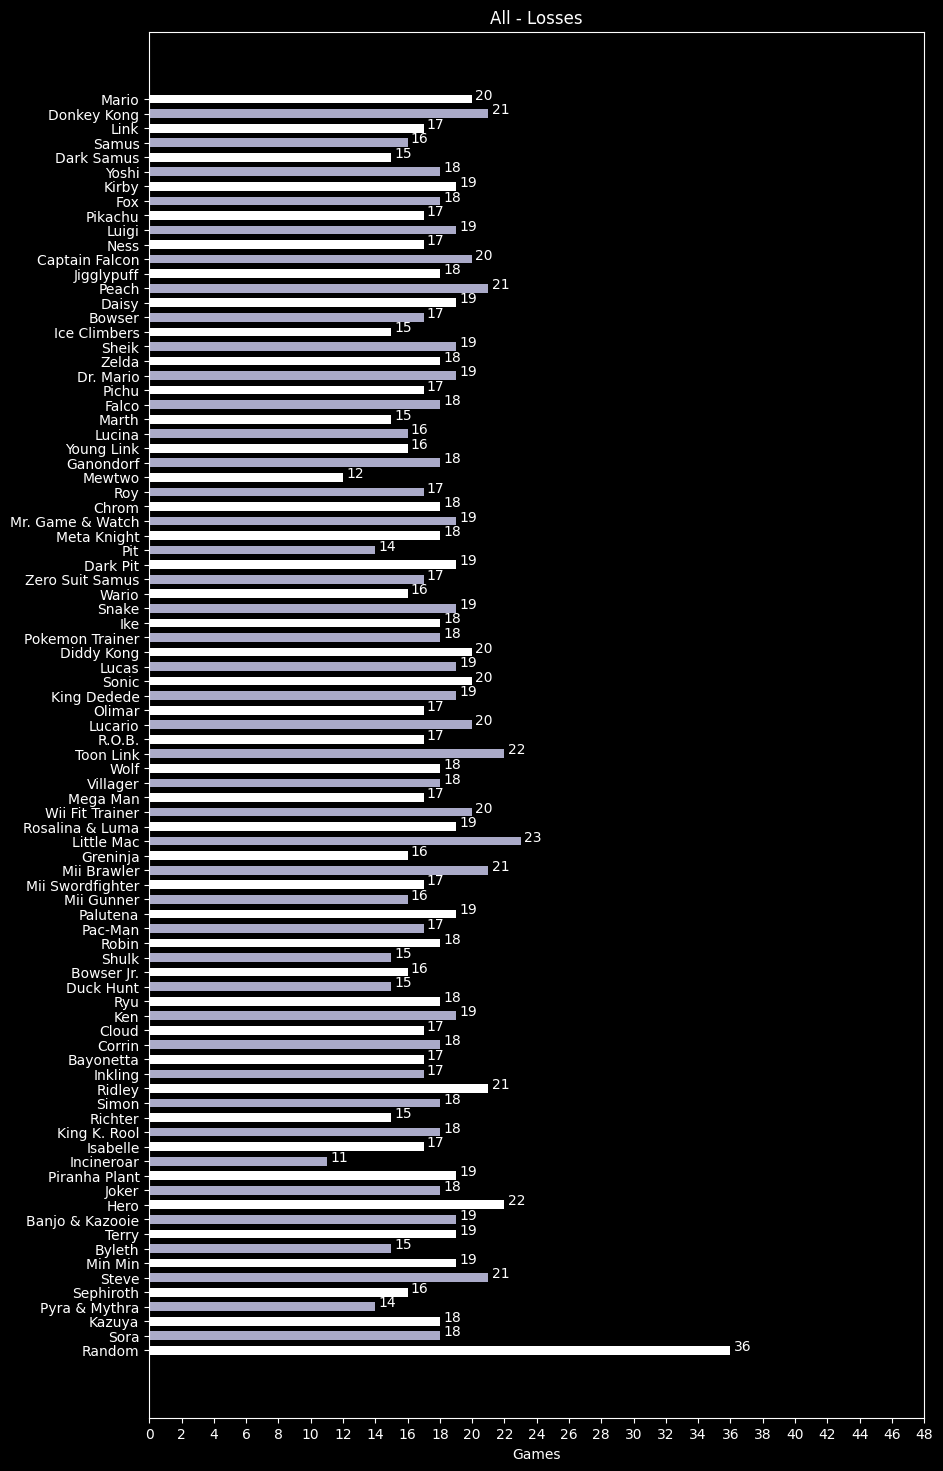

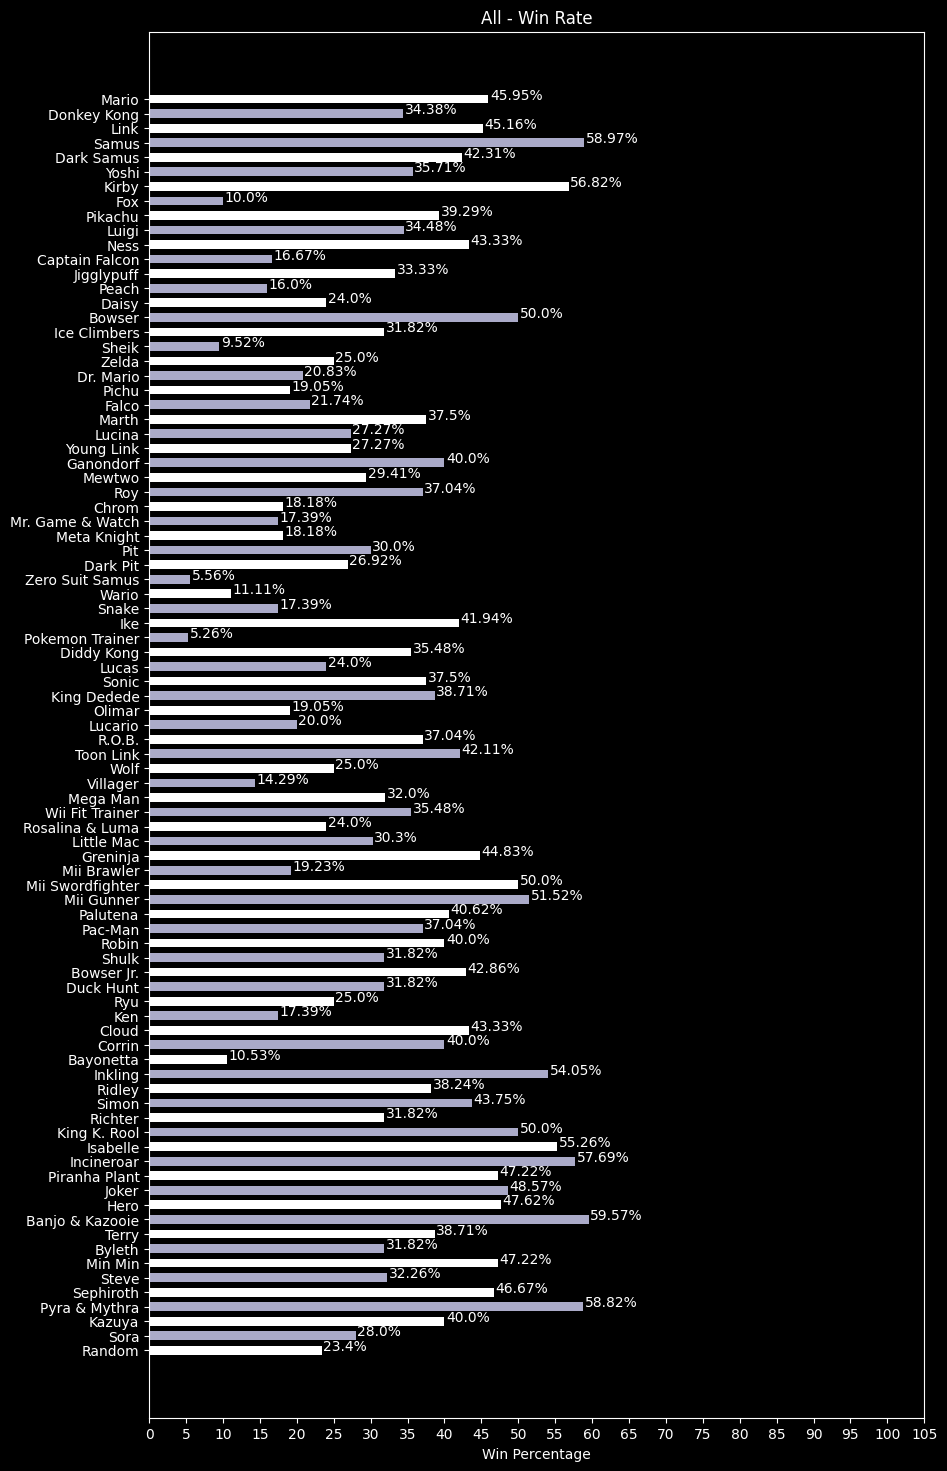

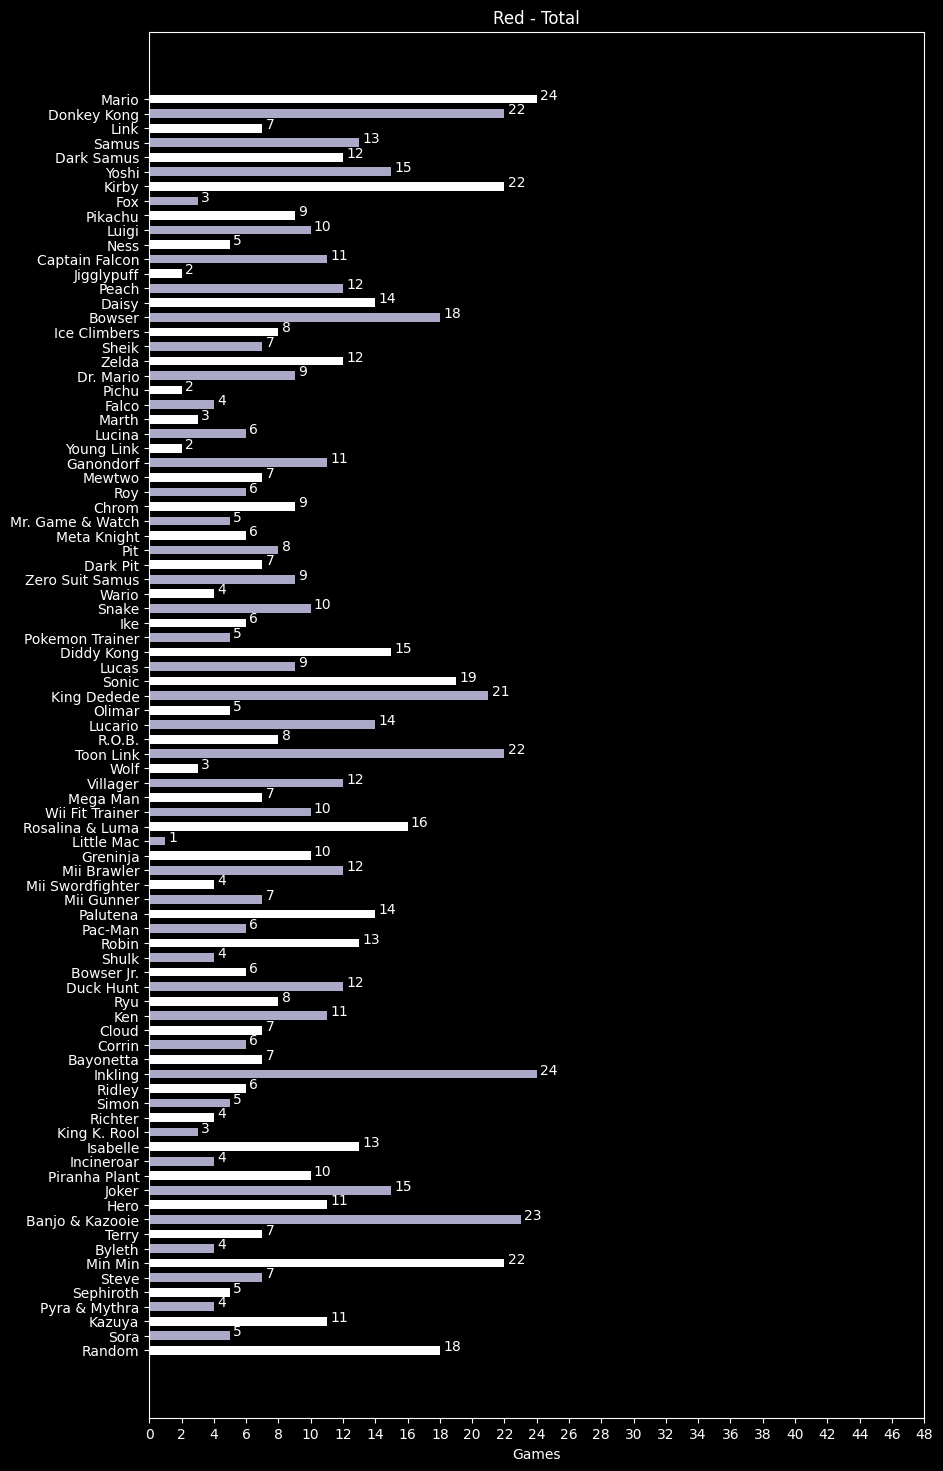

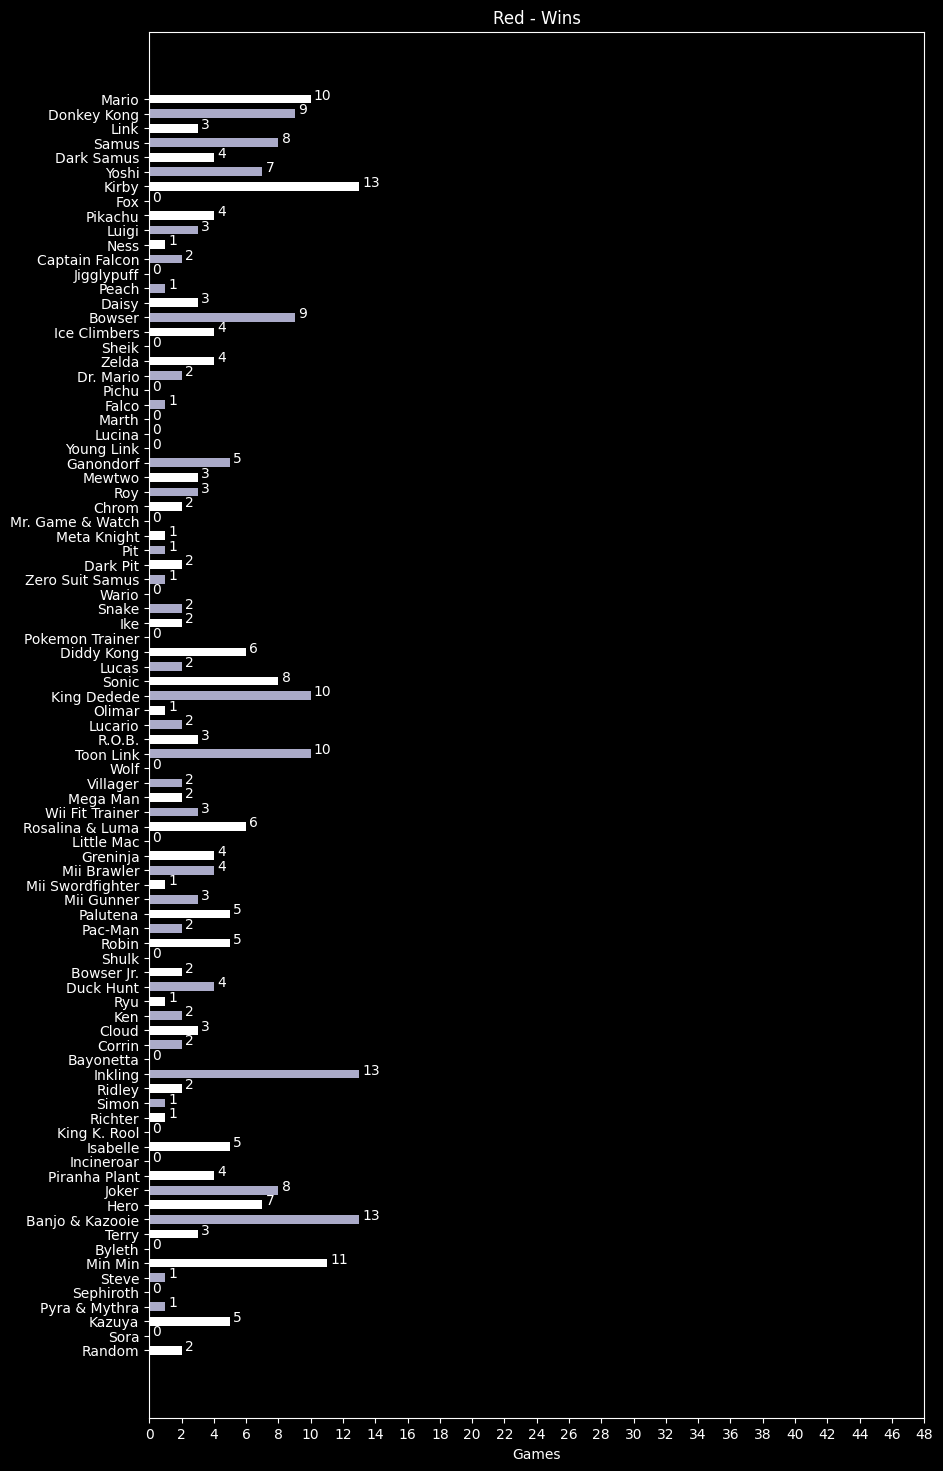

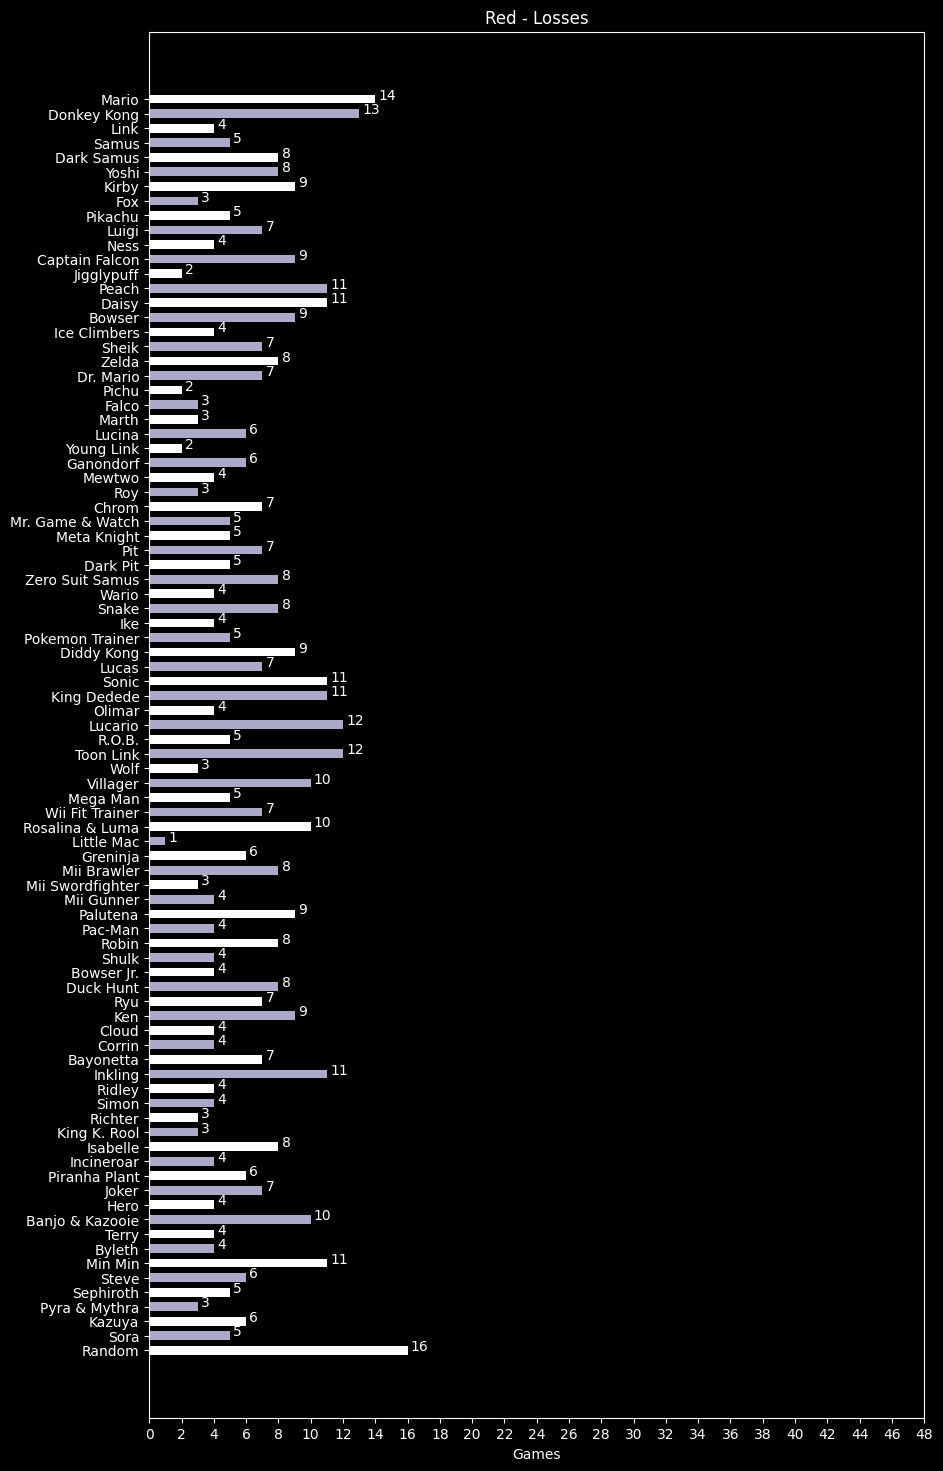

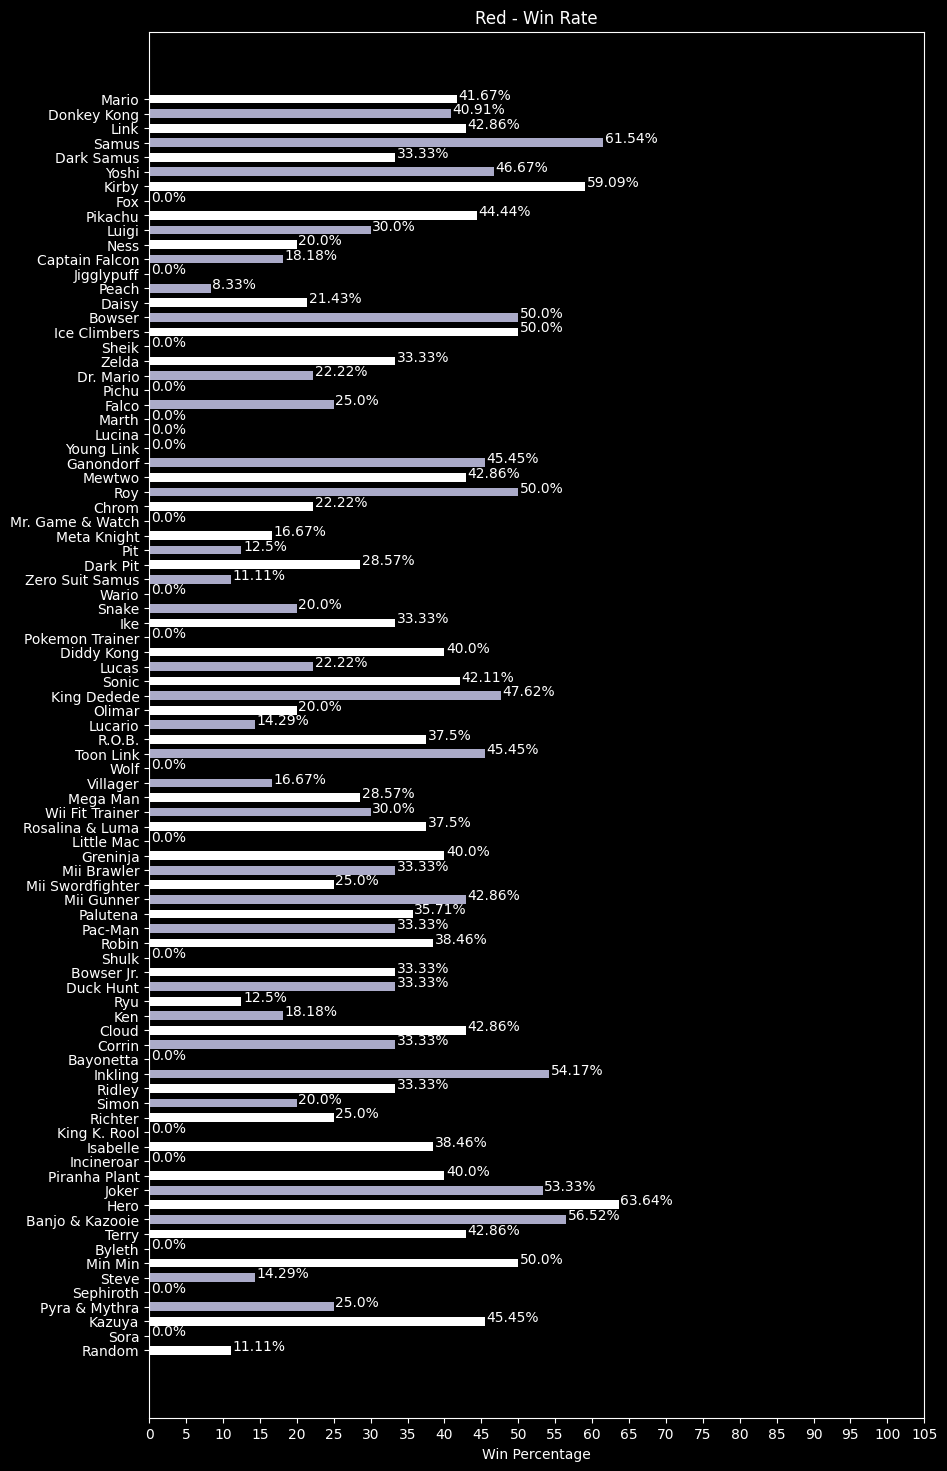

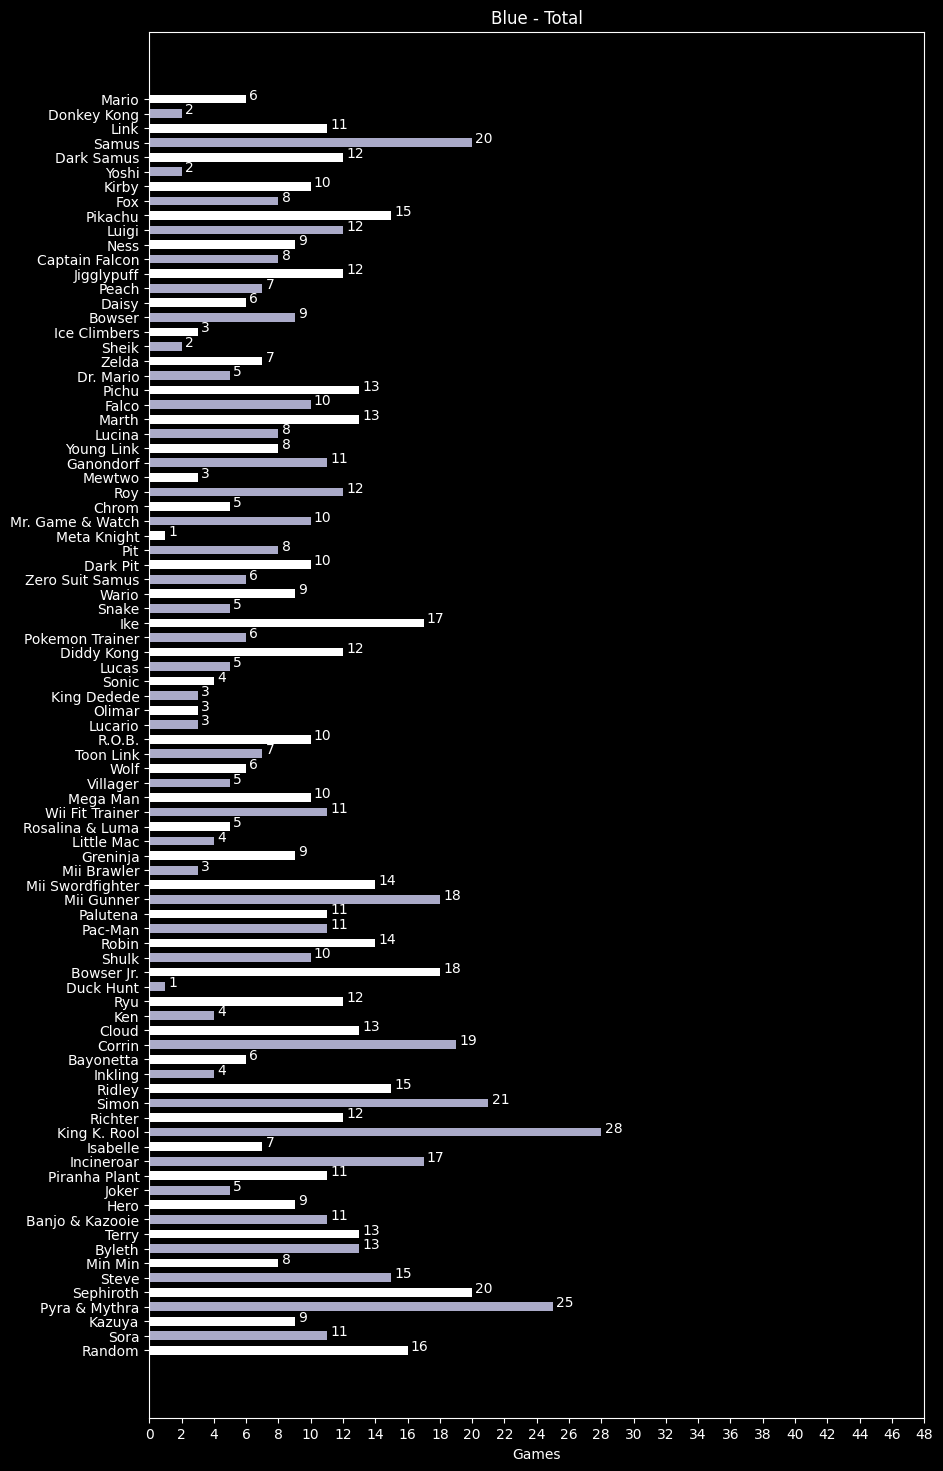

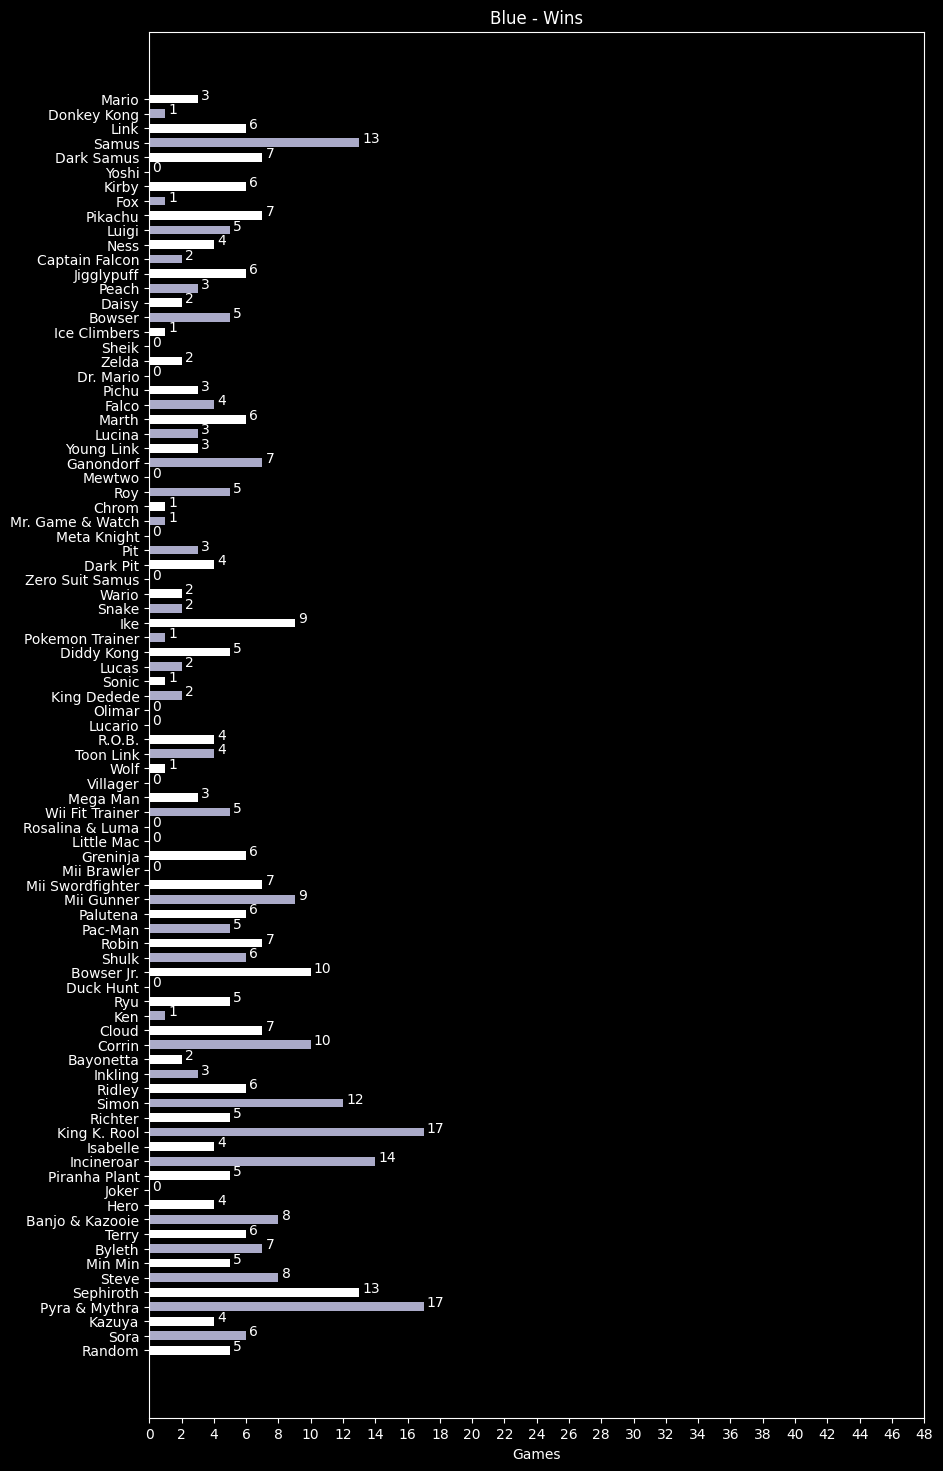

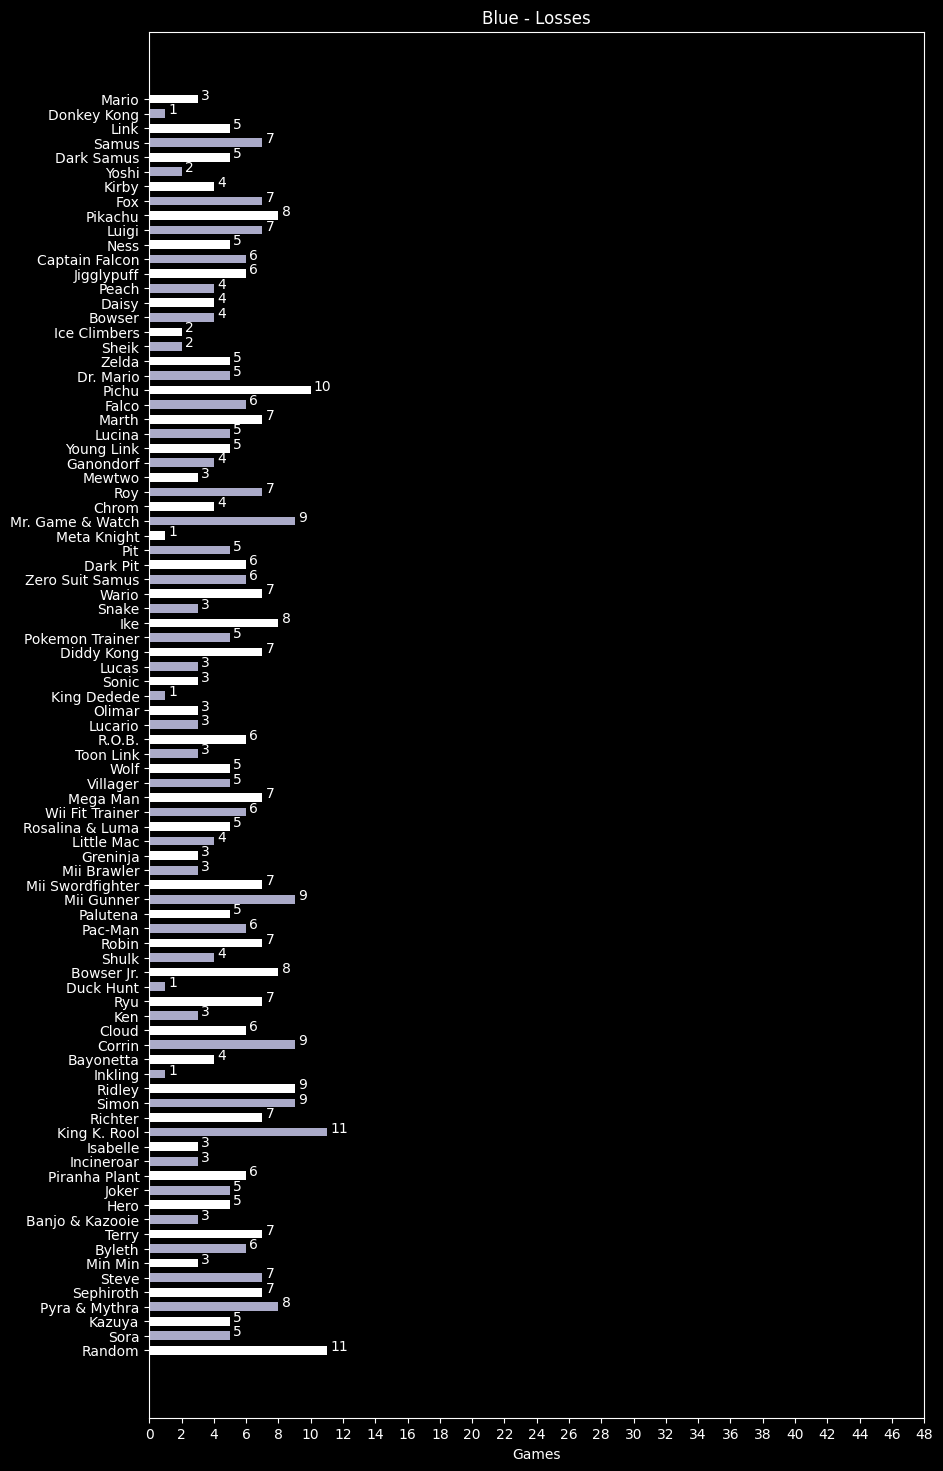

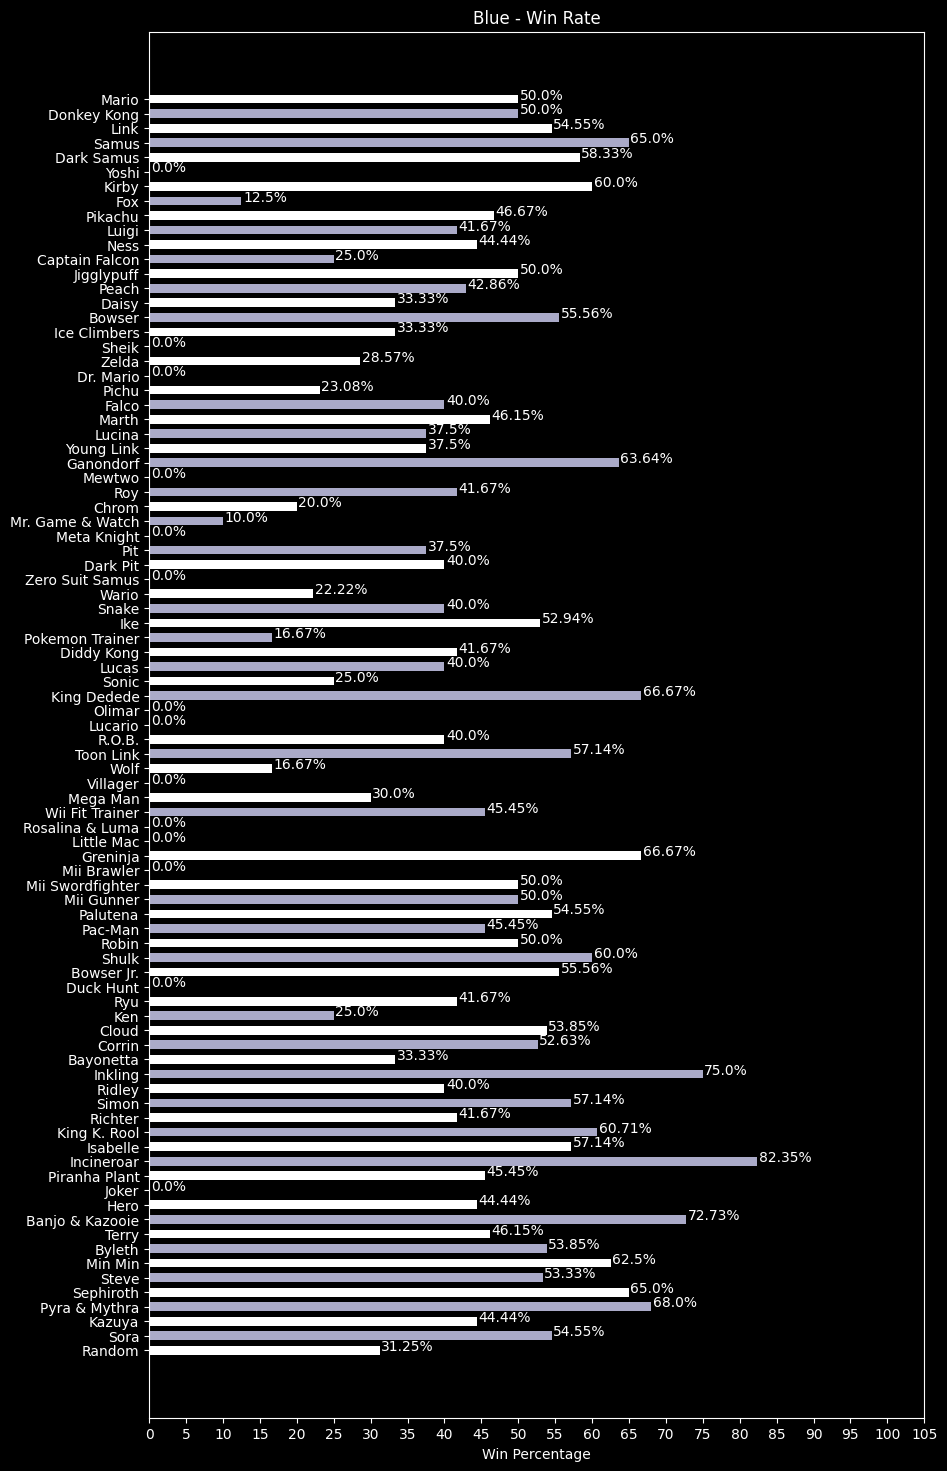

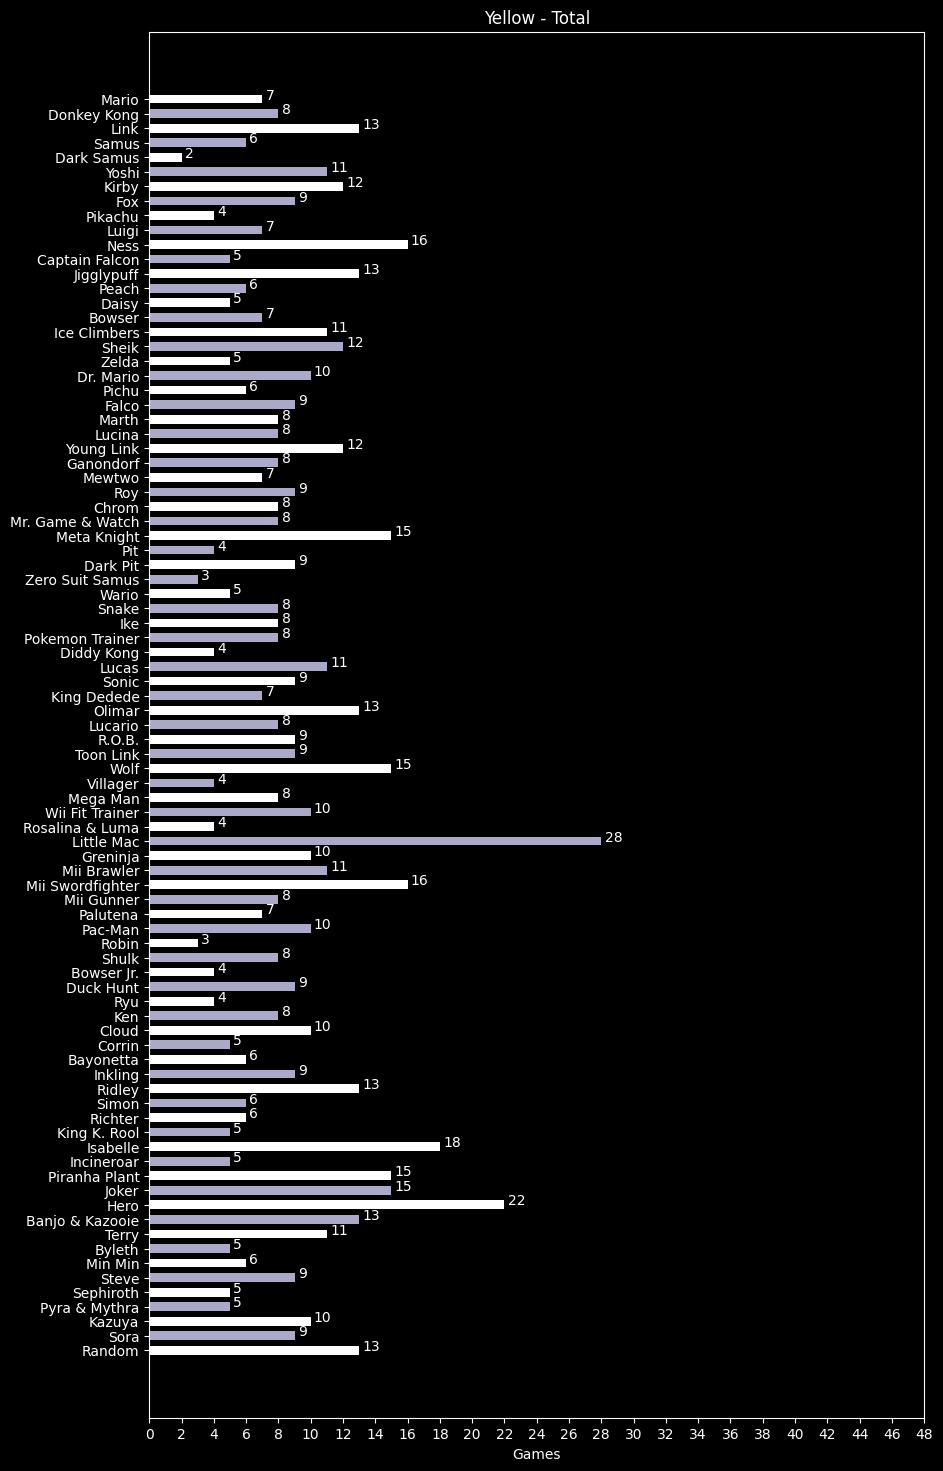

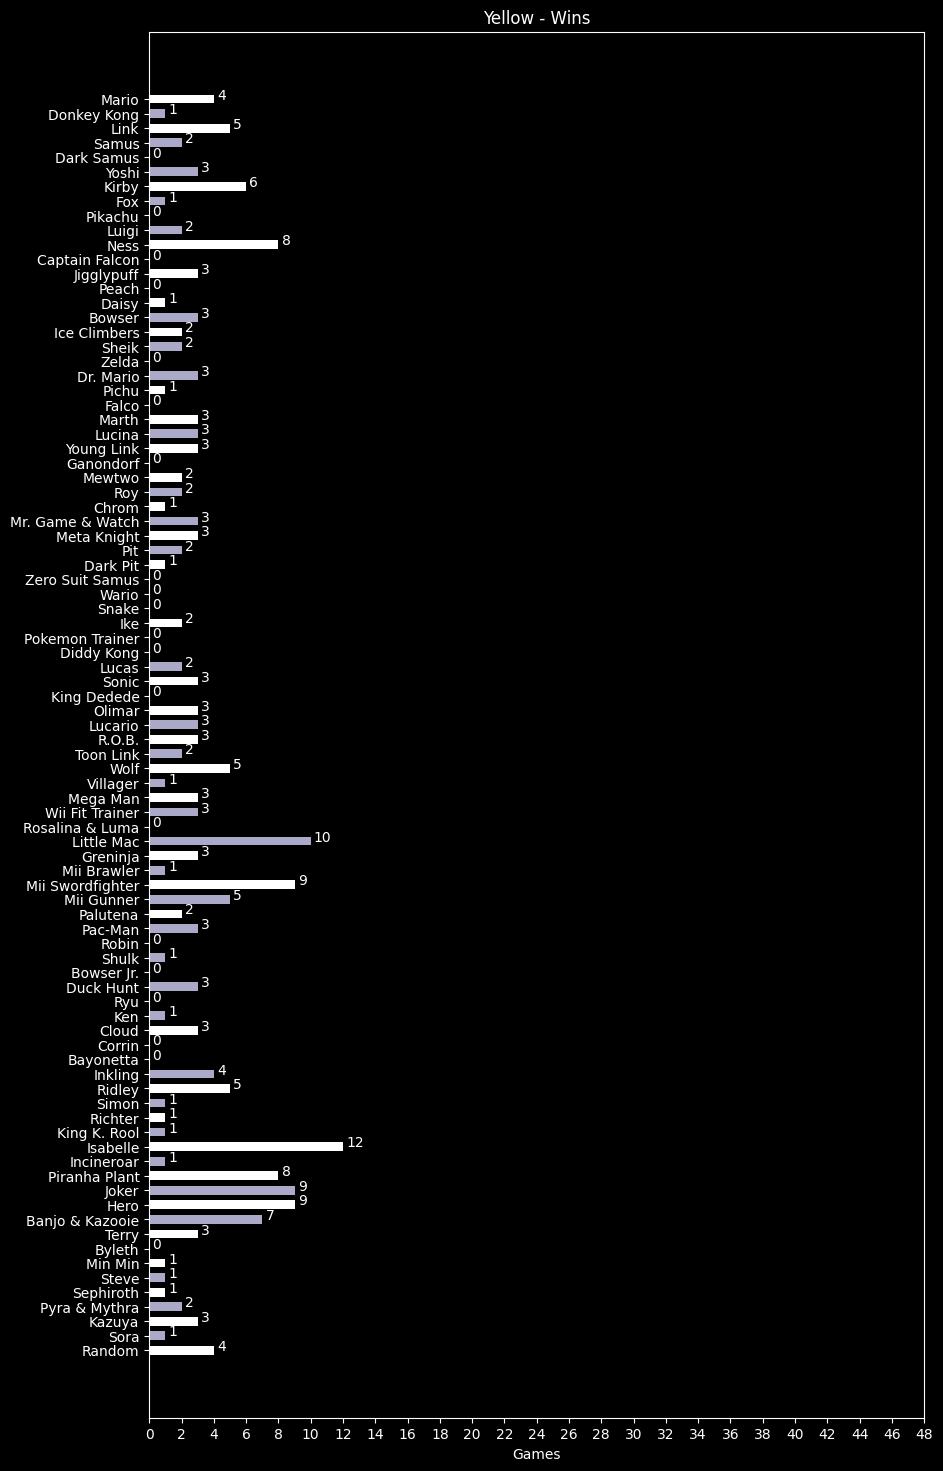

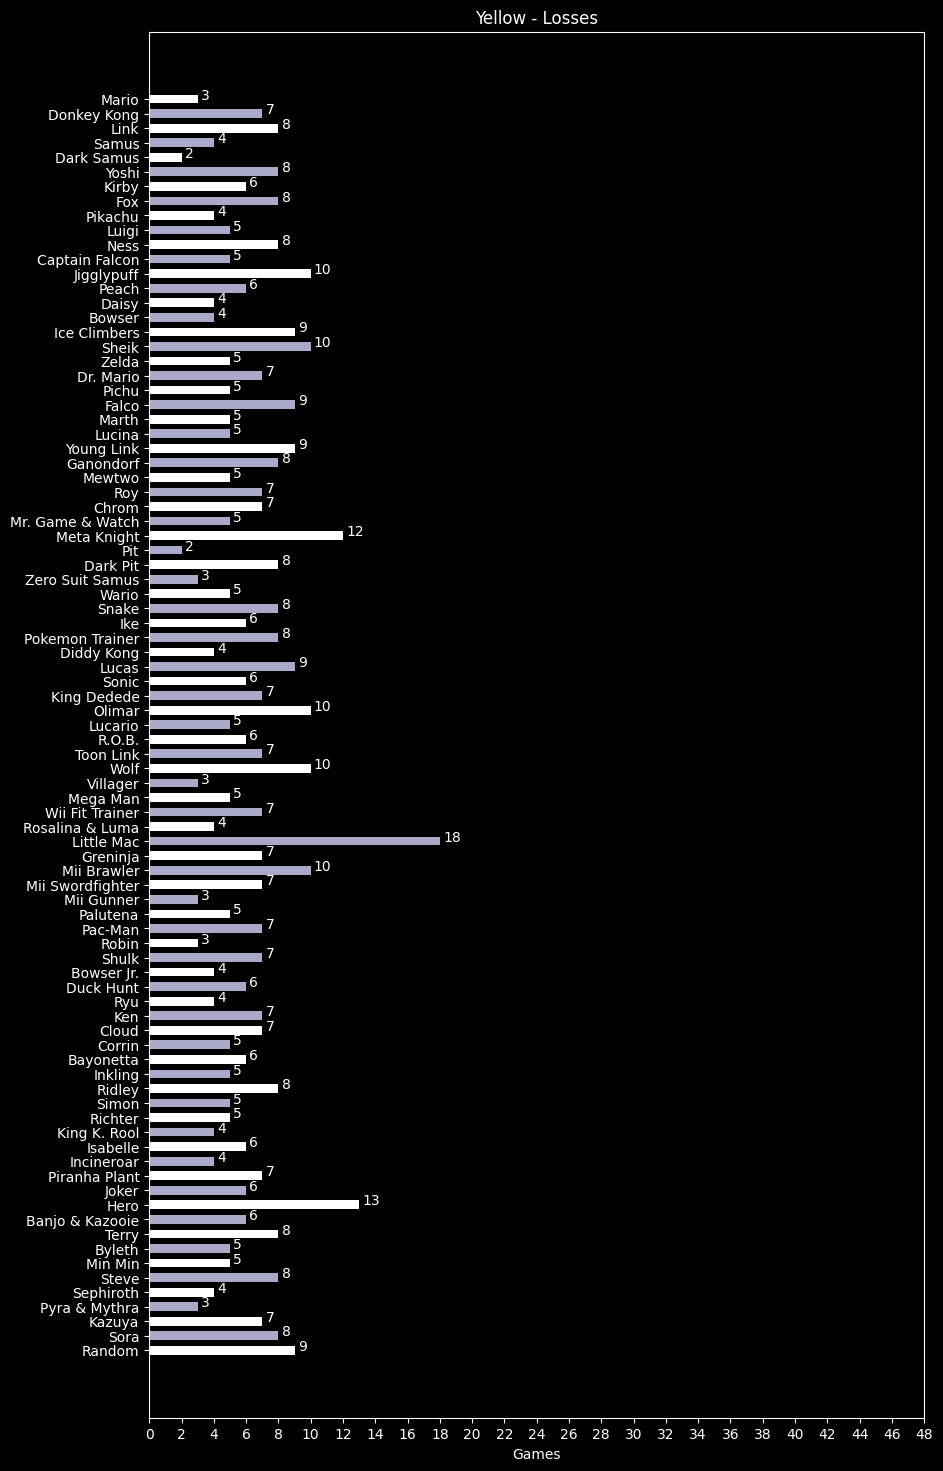

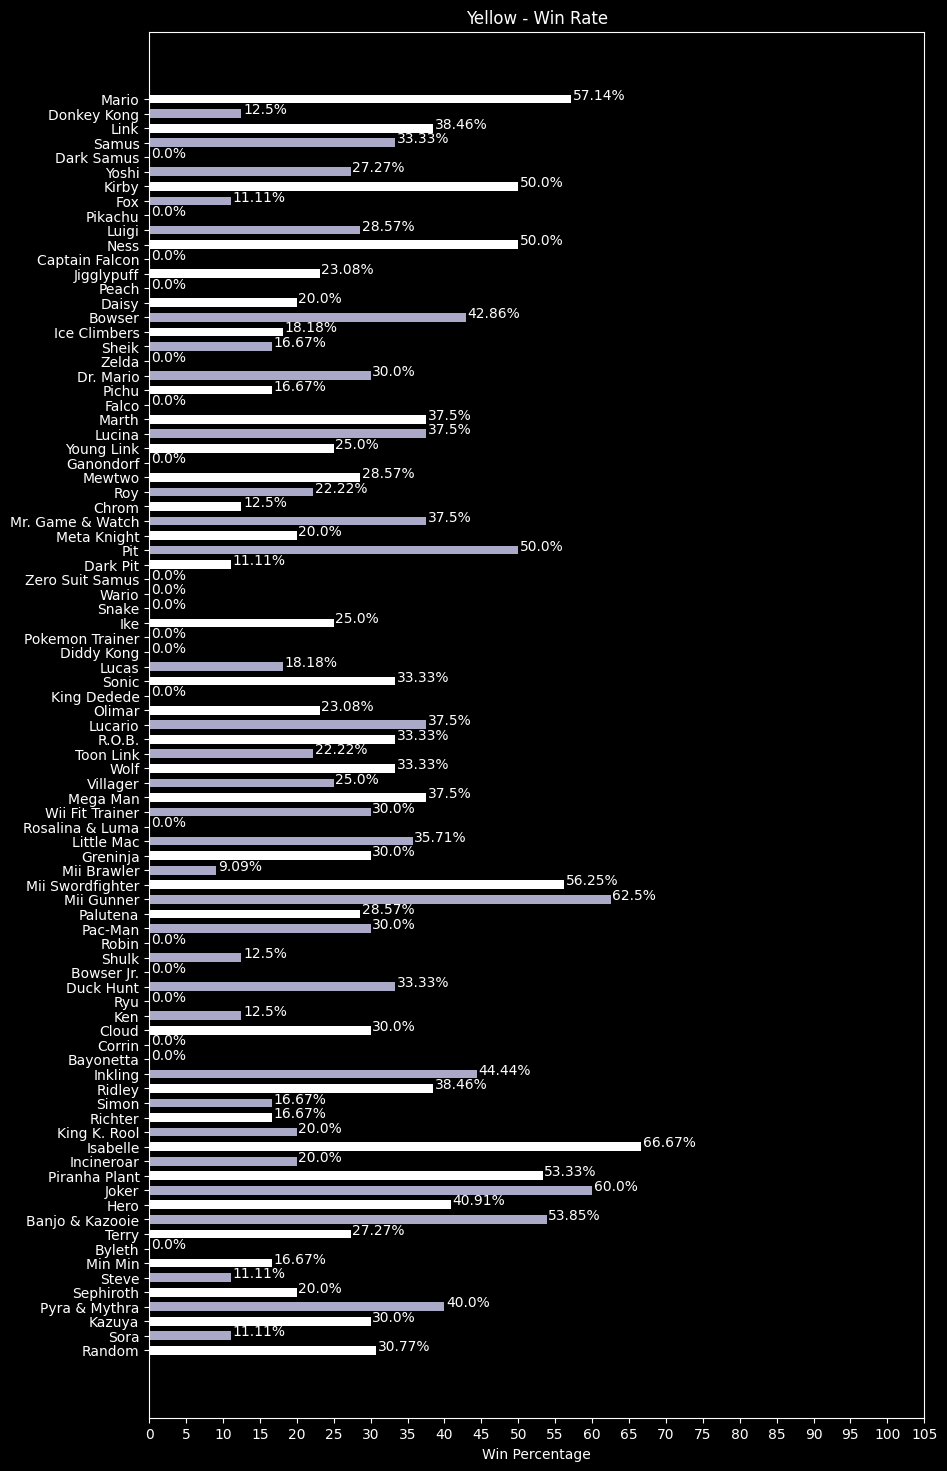

In [88]:
max = characterDict.getMax()
if PLOT_ALL_PLAYERS:
    playerPlot(characterDict.characters, max, True)

# Train Data - Preprocessing & Analysis

In [ ]:
if (MACHINE_LEARNNG): 
    trainDF = pd.read_csv('train.csv')
    trainDF = preproccess(trainDF)

    characterDictTrain = CharacterHolder()
    characterDictTrain.addDF(trainDF)
    characterDictTrain = reorderCharacters(characterDictTrain)

# Train Data - Experiment w/ Model

In [91]:
if (MACHINE_LEARNNG): 
    limit = 50
    step = 20

    trainEncoded = encode(trainDF, ['Red','Blue','Yellow'])
    trainEncoded['Winner'] = lePlayer.fit_transform(trainEncoded['Winner'])
    trainX = trainEncoded.drop('Winner', axis=1)
    trainY = trainEncoded['Winner']


    accuracies = []
    for i in range(1,limit):
        print('\nHidden Layers: ', i*step)
        model = MLP_model(i*step)
        models = model.fit(trainX,trainY)
        accuracies.append(models.history['accuracy'][-1])
        


Hidden Layers:  20
24/24 [==============================] - 1s 1ms/step - loss: 28.4842 - accuracy: 0.2493

Hidden Layers:  40
24/24 [==============================] - 1s 1ms/step - loss: 15.7871 - accuracy: 0.3293

Hidden Layers:  60
24/24 [==============================] - 1s 1ms/step - loss: 8.2671 - accuracy: 0.3103

Hidden Layers:  80
24/24 [==============================] - 1s 2ms/step - loss: 10.1487 - accuracy: 0.3686

Hidden Layers:  100
24/24 [==============================] - 1s 1ms/step - loss: 2.9383 - accuracy: 0.2507

Hidden Layers:  120
24/24 [==============================] - 1s 1ms/step - loss: 8.9496 - accuracy: 0.2615

Hidden Layers:  140
24/24 [==============================] - 1s 2ms/step - loss: 5.2589 - accuracy: 0.2439  

Hidden Layers:  160
24/24 [==============================] - 1s 2ms/step - loss: 1.3943 - accuracy: 0.3442

Hidden Layers:  180
24/24 [==============================] - 1s 1ms/step - loss: 4.5744 - accuracy: 0.2480

Hidden Layers:  200
24/24 

# Accuracy Visualization

C:\Users\somen\AppData\Local\Temp\ipykernel_16492\686635351.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


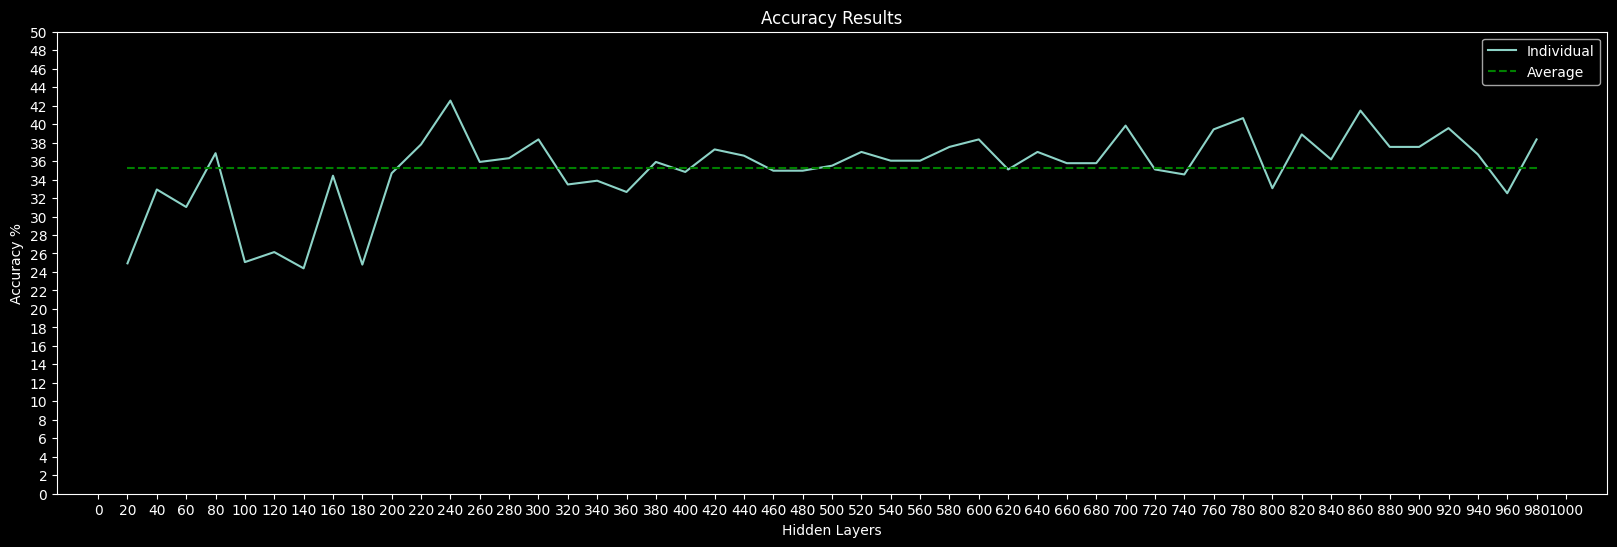

In [92]:
if (MACHINE_LEARNNG): 
    fig, axs = plt.subplots(figsize=(20, 6))
    x = [x*step for x in range(1,limit)]
    y = [y*100 for y in accuracies]
    plt.plot(x, y)
    plt.plot(x, [sum(y) / len(y) for _ in x], 'g--')
    axs.legend(['Individual', 'Average'])
    axs.set_title('Accuracy Results')
    axs.set_xlabel('Hidden Layers')
    axs.set_ylabel('Accuracy %')
    axs.set_yticks(np.arange(0,52, step=2))
    axs.set_xticks(np.arange(0,limit*step+step, step=step))
    fig.show()

# Finalized Model

In [110]:
if (MACHINE_LEARNNG): 
    model = MLP_model(980)
    model.fit(trainX,trainY)

24/24 [==============================] - 1s 3ms/step - loss: 1.2608 - accuracy: 0.4024


# Test - Preprocessing

In [111]:
if (MACHINE_LEARNNG): 
    testDF = pd.read_csv('test.csv')
    testEncoded = encode(testDF, ['Red','Blue','Yellow'])

# Test - Predictions

In [112]:
if (MACHINE_LEARNNG): 
    predictions = model.predict(testEncoded)
    winnersPredict = predictions.argmax(axis=-1)
    winnersPredict = lePlayer.inverse_transform(winnersPredict)


5/5 [==============================] - 0s 2ms/step


# Test - Prediction Accuracy

In [113]:
if (MACHINE_LEARNNG): 
    winnersReal = pd.read_csv('testWinners.csv')
    winnersReal.dropna()
    winnersReal = winnersReal.to_numpy()
    accuracy = accuracy_score(winnersReal, winnersPredict)
    print(accuracy)

0.4838709677419355


# Results to results.csv

In [114]:
if (MACHINE_LEARNNG): 
    resultsDF = testDF.copy()
    resultsDF['Real Winner'] = winnersReal
    resultsDF['Predicted Winner'] = winnersPredict

    resultsDF.to_csv('results.csv', index=False)

# analyze / explain experimental results

In order to find a worthwhile MLP model, I opted to experiement with the number of hidden layers only. I ran the code six times, storing the results in './plots/accuracies'. Overall, it seemed that results were fairly innacurate until there were at least 200 hidden layers. After 200 layers, though, it seemed fairly 50/50 on if any given amount would be above or below average. One particular point sood out to me, though, which was with 980 hidden layers. As one of the few points that was above average for all tests, I opted to use that for my final model. Its performance my have been due to chance, but for the sake of simplicity, it seems reasonable enough to chose it regardless.

# conclusion 

My two goals with this dataset were to provide an extensive amount of visualizations and to create a model that is capable of predicting the winner of any given match of Super Smash Bros. Ultimate. 

As far as the data visualization goes, I am overall very content with what I have. In finding the total amount of times each character plays, wins, losses and their win rate for any given player, there is a lot of very useful and interesting information to look over. As this data is highly personalized, these visualizations are practically meaningless to anybody not directly involved with these matches, but for those involved, these visualizations have been fairly insightful. Overall, I think this aspect of the project was a success.

What is slightly more interesting to discuss in the context of this project, though, is the results of the artificial neural network. After running the model five times, I am seeing that the model is mostly providing an accuracy of <45%, which is a pleasant surprise. I had began this project knowing that the data is recording data that is essentially random. There is missing infomation, such as the stage the match occurred on, and there is also the fact that players, as humans, are inconsistent. Given that you have a one in three chance of getting an accurate prediction simply by guessing, I was anticipating the model to only have an accuracy of at most 40%. The fact that the model has an accuracy that is 15% above random chance is fairly impressive in consideration of how random this data is. With that said, its not entirely perfect. As I mentioned, I had ran the model five times, and some quirks were apparent that I would rather be seeing: 
<br>-For two versions of the model, all of the predictions were for Blue, which resulted in 52% accuracy. 
<br>-Two other version of the model had predictions for both Red and Blue, but none for Yellow. These versions resulted in 45-50% accuracy. 
<br>-The final version of the model had all three players being predicted as some point, but this variant had a relatively low accuracy of 39%.

The best version of the model is the most simple: only ever predict Blue. This isn't exactly surprising, though. As mentioned in the introduction, Blue had a roughly 50% win rate, so a model would do well to be biased towards Blue. I had also brought up that each player has a handful of 'Mains', but with the noticable bias towards Blue, I don't believe it to be worth looking into. All in all, I wouldn't claim that this model is particularly impressive, but I am still impressed with its performance regardless. 